Mounting Google Drive

In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive /Colab Notebooks/Session 7')

In [ ]:
pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing libraries

In [1]:
!git clone https://github.com/RashiTech/main_repo.git

Cloning into 'main_repo'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 23 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), 9.47 KiB | 1.89 MiB/s, done.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2

Updating Device to CUDA

In [3]:
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")

CUDA Available? True


Importing custom modules

In [4]:
from main_repo.models import custom_resnet

In [5]:
from main_repo.models.custom_resnet import resnet

In [6]:
from main_repo.utils import *

In [7]:
from main_repo.train_test import *

Defining data tranformations

In [8]:
# train_transforms = transforms.Compose([
#     transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#     transforms.RandomHorizontalFlip(p=0.3),
#     transforms.RandomRotation((-10., 10.), fill=1),
# #     horizontal flip
# #      shiftScaleRotate
# #     coarseDropout (max_holes = 1, max_height=16px, max_width=16, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     ])

train_transforms = A.Compose(
    [
        A.PadIfNeeded(36,36),
        A.RandomCrop(32, 32),
        A.HorizontalFlip(p=0.2),
        A.CoarseDropout (max_holes = 1, max_height=8, max_width=8, min_holes = 1, min_height=8, min_width=8, fill_value=(0.485, 0.456, 0.406), mask_fill_value = None),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)
test_transforms = A.Compose(
    [
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
    ]
)


Downloading CIFAR 10 dataset and splitting to train and test set

In [9]:
train_data = cifar_ds10('../data', train=True, download=True, transform=train_transforms)
test_data = cifar_ds10('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:13<00:00, 13056232.67it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [10]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Creating Data Loaders from train data and test data

In [11]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

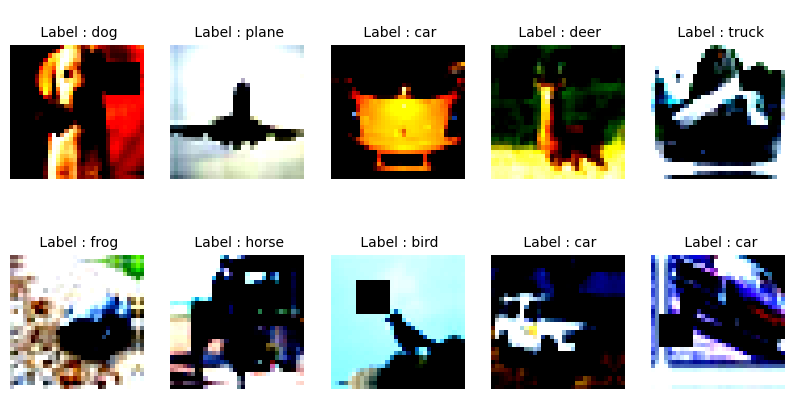

In [12]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print(images.shape)
# print(labels.shape)
# show images
num_of_images = 10
fig = plt.figure(figsize=(10,5))

for index in range(1, num_of_images+1):
    ax = fig.add_subplot(2, 5, index)
    ax.axis('off')
    actual = classes[labels[index]]
    ax.set_title(f'\n Label : {actual}',fontsize=10)
    ax.imshow(np.transpose(images[index], (1, 2, 0)))

In [13]:
pip install torch_lr_finder

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.22E-04


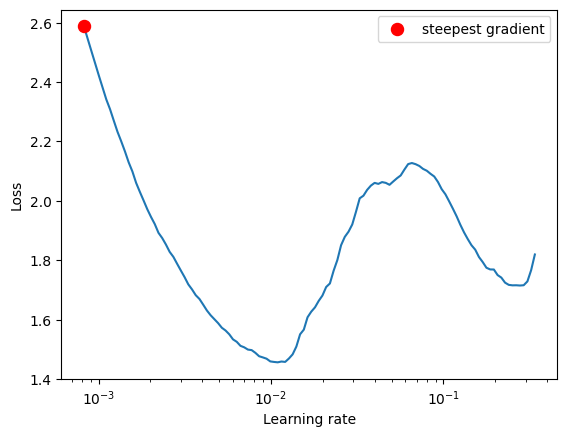

In [14]:
from torch_lr_finder import LRFinder

model = resnet().to(device)
optimizer_lr = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer_lr, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [15]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.010939296658896433


Transferring model to GPU and printing model summary

In [16]:
model1 = resnet(norm='BN').to(device)
summary(model1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
              ReLU-7          [-1, 128, 16, 16]               0
       BatchNorm2d-8          [-1, 128, 16, 16]             256
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
             ReLU-11          [-1, 128, 16, 16]               0
      BatchNorm2d-12          [-1, 128, 16, 16]             256
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

In [17]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []



Training and evaluating the model using One Cycle Policy

In [18]:
model1 =  resnet(norm="BN").to(device)
optimizer = optim.Adam(model1.parameters(), lr=8.22E-04, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
#scheduler = StepLR(optimizer, step_size=6, gamma=0.10)
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='abs')
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr= ler_rate,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=10,
        three_phase=False,
        final_div_factor=10,
        anneal_strategy='linear'
    )
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model1, device, train_loader, optimizer, epoch, scheduler, criterion,train_acc , train_losses)
    test(model1, device, test_loader, criterion,test_acc , test_losses)

EPOCH: 1


Loss=1.3178666830062866 Batch_id=97 Accuracy=44.33: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]



Test set: Average loss: 0.0024, Accuracy: 5709/10000 (57.09%)

EPOCH: 2


Loss=1.0314794778823853 Batch_id=97 Accuracy=62.92: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.0018, Accuracy: 6808/10000 (68.08%)

EPOCH: 3


Loss=0.7990637421607971 Batch_id=97 Accuracy=71.61: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.0016, Accuracy: 7224/10000 (72.24%)

EPOCH: 4


Loss=0.7254773378372192 Batch_id=97 Accuracy=75.71: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]



Test set: Average loss: 0.0015, Accuracy: 7557/10000 (75.57%)

EPOCH: 5


Loss=0.6645917892456055 Batch_id=97 Accuracy=78.87: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]



Test set: Average loss: 0.0013, Accuracy: 7819/10000 (78.19%)

EPOCH: 6


Loss=0.5866369009017944 Batch_id=97 Accuracy=81.21: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]



Test set: Average loss: 0.0012, Accuracy: 8025/10000 (80.25%)

EPOCH: 7


Loss=0.3828684389591217 Batch_id=97 Accuracy=83.68: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]



Test set: Average loss: 0.0010, Accuracy: 8359/10000 (83.59%)

EPOCH: 8


Loss=0.4509594440460205 Batch_id=97 Accuracy=85.57: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]



Test set: Average loss: 0.0010, Accuracy: 8320/10000 (83.20%)

EPOCH: 9


Loss=0.3996233344078064 Batch_id=97 Accuracy=86.54: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]



Test set: Average loss: 0.0010, Accuracy: 8438/10000 (84.38%)

EPOCH: 10


Loss=0.3404727578163147 Batch_id=97 Accuracy=87.60: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]



Test set: Average loss: 0.0009, Accuracy: 8567/10000 (85.67%)

EPOCH: 11


Loss=0.44387099146842957 Batch_id=97 Accuracy=87.99: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]



Test set: Average loss: 0.0008, Accuracy: 8647/10000 (86.47%)

EPOCH: 12


Loss=0.35167041420936584 Batch_id=97 Accuracy=88.68: 100%|██████████| 98/98 [00:21<00:00,  4.66it/s]



Test set: Average loss: 0.0007, Accuracy: 8775/10000 (87.75%)

EPOCH: 13


Loss=0.3262653648853302 Batch_id=97 Accuracy=89.38: 100%|██████████| 98/98 [00:21<00:00,  4.66it/s]



Test set: Average loss: 0.0008, Accuracy: 8727/10000 (87.27%)

EPOCH: 14


Loss=0.3237053453922272 Batch_id=97 Accuracy=89.88: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]



Test set: Average loss: 0.0008, Accuracy: 8727/10000 (87.27%)

EPOCH: 15


Loss=0.19864815473556519 Batch_id=97 Accuracy=90.56: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]



Test set: Average loss: 0.0007, Accuracy: 8863/10000 (88.63%)

EPOCH: 16


Loss=0.2680891454219818 Batch_id=97 Accuracy=91.16: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]



Test set: Average loss: 0.0008, Accuracy: 8754/10000 (87.54%)

EPOCH: 17


Loss=0.2891083061695099 Batch_id=97 Accuracy=92.27: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]



Test set: Average loss: 0.0007, Accuracy: 8852/10000 (88.52%)

EPOCH: 18


Loss=0.20922626554965973 Batch_id=97 Accuracy=92.74: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]



Test set: Average loss: 0.0007, Accuracy: 8923/10000 (89.23%)

EPOCH: 19


Loss=0.14483392238616943 Batch_id=97 Accuracy=93.60: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]



Test set: Average loss: 0.0006, Accuracy: 9043/10000 (90.43%)

EPOCH: 20


Loss=0.1290375292301178 Batch_id=97 Accuracy=94.50: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]



Test set: Average loss: 0.0006, Accuracy: 9038/10000 (90.38%)

EPOCH: 21


Loss=0.1162698045372963 Batch_id=97 Accuracy=95.18: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]



Test set: Average loss: 0.0006, Accuracy: 9077/10000 (90.77%)

EPOCH: 22


Loss=0.15718026459217072 Batch_id=97 Accuracy=96.14: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]



Test set: Average loss: 0.0005, Accuracy: 9123/10000 (91.23%)

EPOCH: 23


Loss=0.11191421747207642 Batch_id=97 Accuracy=97.15: 100%|██████████| 98/98 [00:21<00:00,  4.66it/s]



Test set: Average loss: 0.0005, Accuracy: 9194/10000 (91.94%)

EPOCH: 24


Loss=0.05899084731936455 Batch_id=97 Accuracy=97.83: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]



Test set: Average loss: 0.0005, Accuracy: 9248/10000 (92.48%)



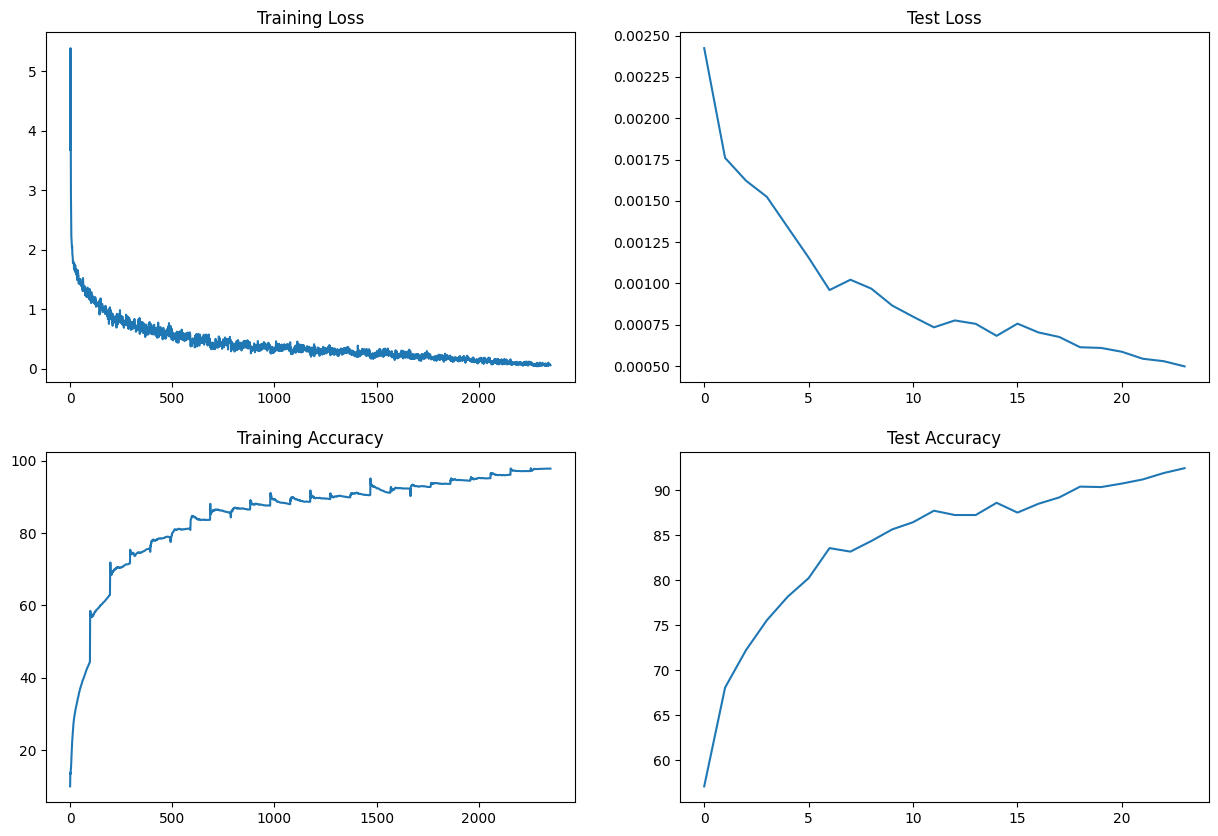

In [19]:
train_losses = [t_items.item() for t_items in train_losses]
plot_graphs(train_losses, train_acc, test_losses ,test_acc)

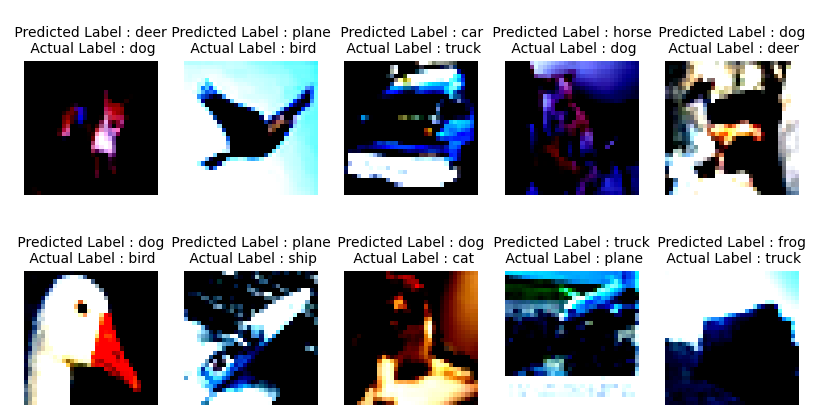

In [20]:
wrong_prediction_list = []
model1.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    output = model1(images)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    match = pred.eq(labels.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(match):
        if(i == False):
            wrong_prediction_list.append((images[j], pred[j].item(), labels[j].item()))
display_incorrect_images(wrong_prediction_list, n=10 )